# 1. Infer PCD subtypes

In [88]:
## Import libraries 
import os
import pandas as pd
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
## Set working directory
os.chdir("/Path/To/Your/Working Directory/") 
dir = 'Output/1-Infer_PCD_subtype/'
os.makedirs(dir, exist_ok = True)

In [90]:
## Configuration
Model = xgb.XGBClassifier()
Model.load_model("Utility/Model.model")
Mapping = {0: "CD-P", 1: "CD-PN", 2: "CD-NF", 3: "CD-FA", 4: "CD-A"}
cmap = {"CD-P": "#fdcc83", "CD-PN": "#f6afb0", "CD-NF": "#c27cd6", "CD-FA": "#71b3a8", "CD-A": "#6292b0"}

## 1. Prepare Data

In [ ]:
## If you start from a log2-transformed tpm-quantified expression matrix:
# Expr_raw = pd.read_csv('Path/To/Your/Data.tsv', delimiter = '\t')
# Expr_raw = Expr_raw.set_index("Gene")
# # Step 1: Select PCD genes
# PCD_Gene = pd.read_csv('Utility/PCD_Gene.tsv', delimiter = '\t')
# Expr_PCD = Expr_raw.loc[list(set(Expr_raw.index) & set(PCD_Gene['Gene']))].T
# Expr_PCD.index.name = 'ID_sample'
# # Step 2: Median scaling
# from sklearn.preprocessing import RobustScaler
# Expr = pd.DataFrame(RobustScaler().fit_transform(Expr_PCD), index = Expr_PCD.index, columns = Expr_PCD.columns)
# Expr

In [92]:
# Load the PCD Expression data (Make sure the expression matrix have been median-scaled)
Expr = pd.read_csv('Data/CPTAC/PCD_Expr.tsv', delimiter = '\t')
Expr = Expr.set_index("ID_sample")

## 2. Infer subtypes

In [93]:
## Predict
Expr = Expr.reindex(columns = Model.get_booster().feature_names)
Predicted_subtype = Model.predict(Expr)
Predicted_subtype_proba = Model.predict_proba(Expr)

Prediction = pd.DataFrame(Predicted_subtype, columns=['Subtype'])
Prediction['Subtype'] = Prediction['Subtype'].map(Mapping)
for i in range(5):
    Prediction['Probability_' + Mapping[i]] = Predicted_subtype_proba[:, i]
Prediction["Max_Probability"] = Prediction[[c for c in Prediction.columns if c.startswith("Probability_")]].max(axis = 1)
Prediction['ID_sample'] = Expr.index
Prediction = Prediction.set_index("ID_sample")

Prediction.to_csv(dir + 'Prediction.tsv', sep = '\t', index = True)
Prediction

,Subtype,Probability_CD-P,Probability_CD-PN,Probability_CD-NF,Probability_CD-FA,Probability_CD-A,Max_Probability
ID_sample,,,,,,,
25-R,CD-NF,0.004475,0.026082,0.801101,0.165107,0.003236,0.801101
350-R,CD-P,0.987710,0.012045,0.000242,0.000002,0.000002,0.987710
345-R,CD-PN,0.482265,0.484402,0.013533,0.006807,0.012993,0.484402
349-R,CD-FA,0.000018,0.004458,0.000979,0.994444,0.000101,0.994444
26-R,CD-PN,0.007576,0.559092,0.233107,0.043020,0.157205,0.559092
...,...,...,...,...,...,...,...
40f58bf3-58bc-4b65-a88e-821ee9d24b9f,CD-NF,0.019419,0.016629,0.848896,0.113405,0.001651,0.848896
822979b4-f4b9-4ca2-85e8-029feb9e7500,CD-FA,0.000052,0.004054,0.015999,0.978480,0.001416,0.978480
CPT0246990009,CD-FA,0.006019,0.002776,0.038008,0.943117,0.010080,0.943117


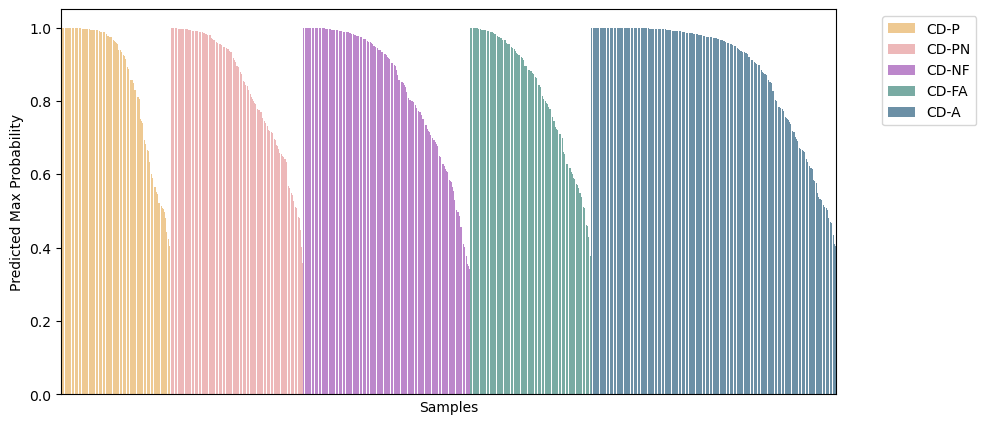

In [94]:
## Plot probability
Prediction["Subtype"] = pd.Categorical(Prediction["Subtype"], categories = ["CD-P", "CD-PN", "CD-NF", "CD-FA", "CD-A"], ordered = True)
Prediction = Prediction.sort_values(by = ["Subtype", "Max_Probability"], ascending = [True, False])
Prediction.index = pd.Categorical(Prediction.index, categories = Prediction.index, ordered = True)
plt.figure(figsize=(10, 5))
sns.barplot(
    data = Prediction,
    x = Prediction.index,
    y = "Max_Probability",
    hue = "Subtype",
    dodge = False,
    palette = cmap
)
plt.xlabel("Samples")
plt.ylabel("Predicted Max Probability")
plt.xticks([], [])
plt.legend(bbox_to_anchor = (1.05, 1), loc = 'upper left')
plt.savefig(dir + 'Prediction_probability.png', dpi = 300, bbox_inches = 'tight')
plt.show()